# Imports

`TODO: Remove unnecessary imports`

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from livelossplot import PlotLossesKeras

from keijzer import *


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

In [51]:
# Setup (multi) GPU usage with scalable VRAM
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load the data

In [52]:
%pwd

'D:\\Brian\\JupyterLab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [53]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [54]:
df.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,16,1,1


# Preprocessing
Prepare the data for the used model.

In [55]:
data = df.copy()

## Datetime info to categorical
Certain functions are able to use the Pandas categorical datatype, e.g. they don't require the feautures to be one-hot encoded.  

In [56]:
columns_to_category = ['hour', 'dayofweek', 'season']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# One hot encoding // dummy variables
One hot encode the categorical feautures.

In [57]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,...,1,0,0,0,0,0,1,0,0,0


# Create a train & test set
The original DataFrame will be sliced up into a train and test set.  
See the plot below for clarification.  
The test set is used for the model cross-validation, decisions about the architecture and hyperparameters should not be made based on the test set.

In [58]:
from sklearn.model_selection import train_test_split

X = data.drop(['gasPower'], axis=1)
#print('X columns: %s' % list(X.columns))

y = data['gasPower']

#X = np.array(X).reshape(-1,len(X.columns)) # Reshape to required dimensions for sklearn
#y = np.array(y).reshape(-1,1)

train_size = 0.7

split_index = int(data.shape[0]*train_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

# Visualization of the train & test set target values

## The complete dataset

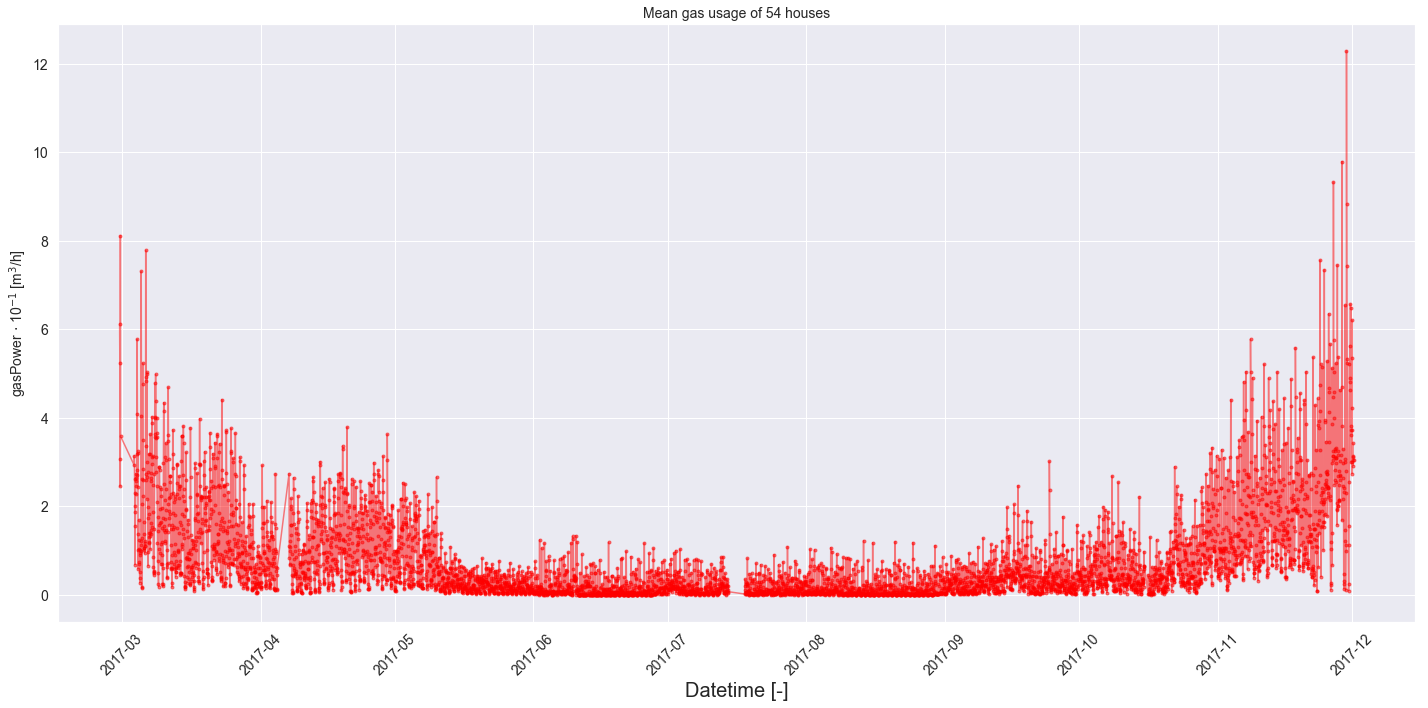

In [59]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Mean gas usage of 54 houses', fontsize=14)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

## The train & test set

Get the `X_train` and `X_test` datetime values.  

In [60]:
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

Create the plot.

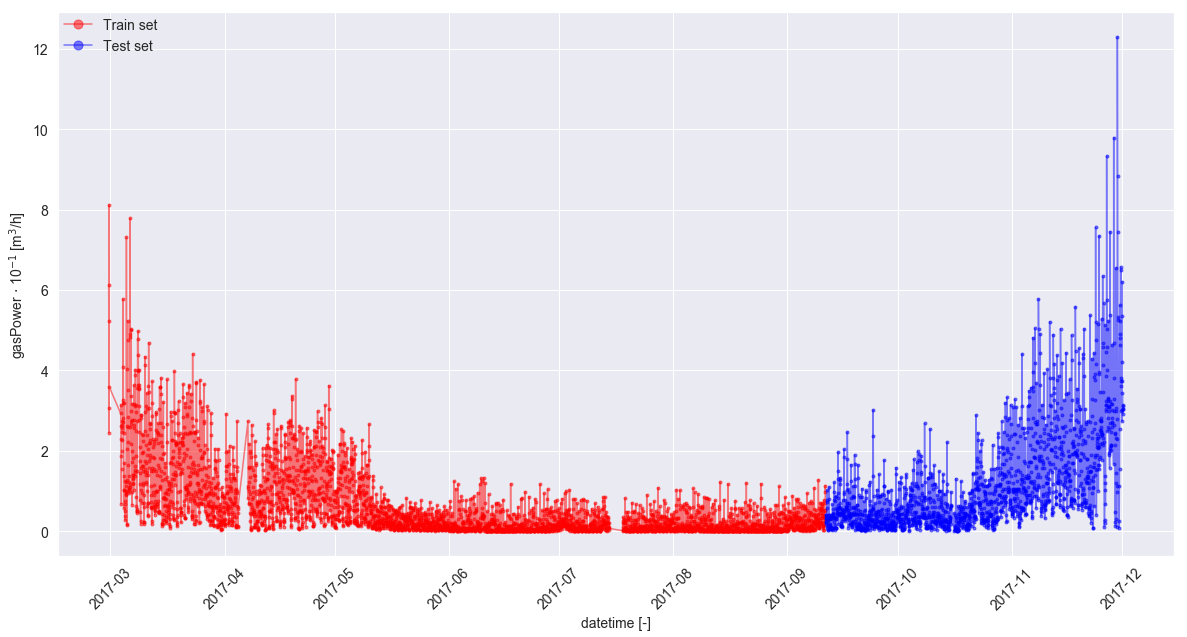

In [61]:
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

# Feature scaling
First fit the `StandardScaler()` to `X_train`.  
Then transform `X_train` and `X_test`, this way there is no data leakage from the `X_test` dataset.  
Note that the target $y$ does not need to be scaled.  
Feautures are scaled because they're an input to the neural network (NN), literature about this can be found online.  
Basically the NN converges best when the inputs are on the same scale from around -1 to 1.  

In [62]:
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)

X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

print((X_train.shape, y_train.shape))

print((X_test.shape, y_test.shape))

c:\program files\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


((4446, 44), (4446,))
((1906, 44), (1906,))


# Feedforward DNN model

Set seed, this will be used to always get the same 'random' values for things that are random.  
This way the results are reproducable.  

Layers will be initialized using `TrancatedNormal`, for more info see [link](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404) or take a look at the Keras documentation.  
The activation function being used is `LeakyReLU`, for more info see [link](https://medium.com/@shrutijadon10104776/survey-on-activation-functions-for-deep-learning-9689331ba092), or take a look at the Keras documentation.  
Dropout is being used to prevent overfitting.  

Why this configuration of nodes and layers?  
It proved itself to give the best results in comparison to other configurations.  
[Hyperas](https://github.com/maxpumperla/hyperas) could be used to find the most ideal model architecture.  

The loss function being used is MSE because it converges the best.  
However, two percentage error metrics (MAPE and SMAPE) are being used as an extra way of looking at the model accuracy (wikipedia them to see the math, or look in keijzer.py).  

In [63]:
seed = 42

# Initialize the model
model = Sequential()

# Input layer
model.add(Dense(16, input_shape=(X_train.shape[1],), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
model.add(Dropout(0.5, seed=seed)) 

# Dropout: 1 wont ''drop'' any data, 0.5 will drop half of the data
# https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network

# Create 4 hidden layes with (N-i*4) nodes each.
N = 256
for i in range(4): # 4
    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
    model.add(LeakyReLU())
    model.add(Dropout(0.5, seed=seed))

# Output layer
model.add(Dense(1))

## Evaluation metrics
The MSE has been given in the first notebook.  
For the other models the Mean Absolute Percentage Error (MAPE) and the Symmetric Mean Absolute Percentage Error (SMAPE) will be used, along with the MSE.  
Whith the the definitions of the metrics are as follows.  

$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \frac{| \hat{Y_i} - Y_i |}{| \hat{Y_i} | }$  

$SMAPE = \frac{100\%}{n} \sum_{i=1}^{n} \frac{| Y_i - \hat{Y_i} |}{|\hat{Y_i}| + |Y_i |} \cdot \frac{1}{2}$

Where $\hat{Y_i}$ is the real value and $Y_i$ the predicted value of the $i$-th sample, with a total number of $n$ samples.

MAPE and SMAPE are being used since they are easier to interpred them, with them being in percentages. 

# Compile the model
Also set some hyperparameters like the learning rate (lr), amount of epochs and the batch size (bs).  
The batch size is the amount of samples that the loss functions 'sees' before 'deciding' how to change which weight, in order to make the model converge.  
Weights arn't changed untill all batches have passed.  

For example:  
When the batch size is five and the used loss function is stochastic gradient decent (sgd) in $\mathbb{R}^3$, then sgd will be used to calculated  how to change which weights for 5 times before actually changing them.  
After all  5 batches have passed, the weights will be changed in such a way that it is the 'best' step down in space (so the model will converge the most).

In [64]:
#model = multi_gpu_model(model, gpus=num_gpu) # use this to use multiple GPUs

lr = 1e-2
epochs = 75 # Two times
bs = 2**13
decay_rate = 1*10**(-8)

sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)

# compiling the sequential model
model.compile(loss='mse', metrics=[mape, smape], optimizer=adam)

print('Batch size: ', bs)

Batch size:  8192


# Fit the model

`EarlyStopping()` can be used as a call back to stop the training process once the model has no longer improved after the set `patience` number.  
`ModelCheckpoint()` is being used to automatically save the best model, om this case it is based on the minimum reached value of `val_mape`. 

In [65]:
early_stopping_monitor = EarlyStopping(patience=5000) # Not using earlystopping monitor for now, that's why patience is high

# This is used to save the best model, currently monitoring val_mape
# checkpoint
filepath="models\\DNN.best.hdf5" # Save it in the models folder with name DNN.best and filetype hdf5
checkpoint = ModelCheckpoint(filepath, monitor='val_mape', verbose=1, save_best_only=True, mode='min')

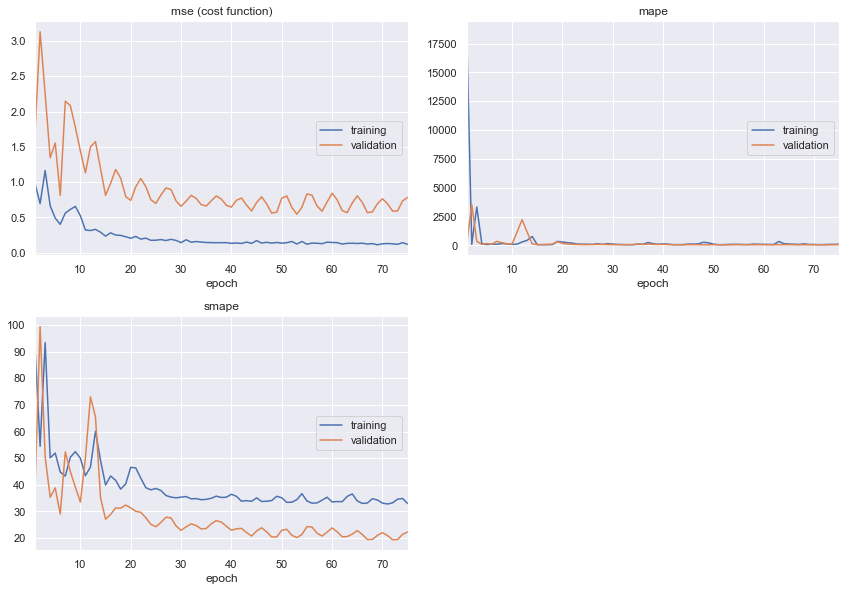

mse (cost function):
training   (min:    0.111, max:    1.164, cur:    0.118)
validation (min:    0.544, max:    3.132, cur:    0.783)

mape:
training   (min:   58.653, max: 18532.834, cur:  104.772)
validation (min:   52.569, max: 3552.755, cur:   62.932)

smape:
training   (min:   32.768, max:   93.401, cur:   32.937)
validation (min:   19.369, max:   99.454, cur:   22.226)


In [66]:
# training the model and saving metrics in history
model.fit(X_train, y_train, batch_size=bs, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, checkpoint, PlotLossesKeras()])

# Load the saved model

In [67]:
%time
from keras.models import load_model

# Load the architecture
model = load_model('models\\DNN.best.hdf5', custom_objects={'smape': smape, 
                                                    'mape': mape}) # Gave an error when loading without 'custom_objects'.. fixed by https://github.com/keras-team/keras/issues/3911

# Compile with the same settings as it has been saved with earlier
model.compile(loss='mse', metrics=[mape, smape], optimizer=adam)

print('FINISHED')

Wall time: 0 ns
FINISHED


# Cross validate on the test set

In [68]:
y_pred = model.predict(X_test)
y_true = y_test.values.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)

1906/1906 [==============================] - 0s 149us/step
FINISHED


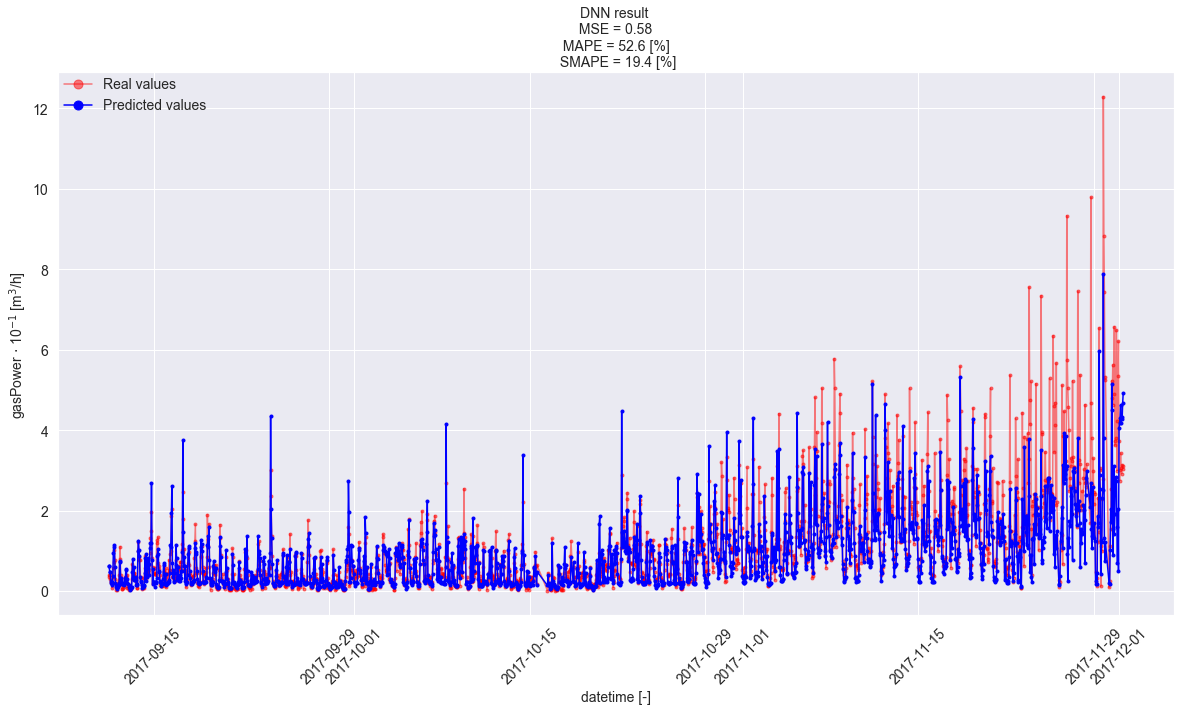

In [69]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result, mape_result, smape_result = model.evaluate(X_test, y_test)

plt.title('DNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')

# Downsample these results to a day

In [70]:
# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_pred) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

# Save the model results for later usage
result.to_csv('models\\DNN_predictions.csv')

result = result.resample('D').sum() # Resample data

result = result.dropna()

(1906,)


In [71]:
# Calculate evaluation metrics over the result

ytrue = result['y_true']
ypred = result['y_pred']
n = len(result)

# Recalculated the metrics for the downsampled results
mse_result = (1/n)*np.sum((ypred - ytrue)**2)
mape_result = (100/n) * np.sum(np.abs((ytrue - ypred) / ypred))
smape_result = (100/n) * np.sum( np.abs((ytrue - ypred)) / (np.abs(ytrue) + np.abs(ypred)) )

Text(0.5, 1.0, 'DNN result \n MSE = 106.04 \n MAPE = 23.0 [%] \n SMAPE = 10.0 [%]')

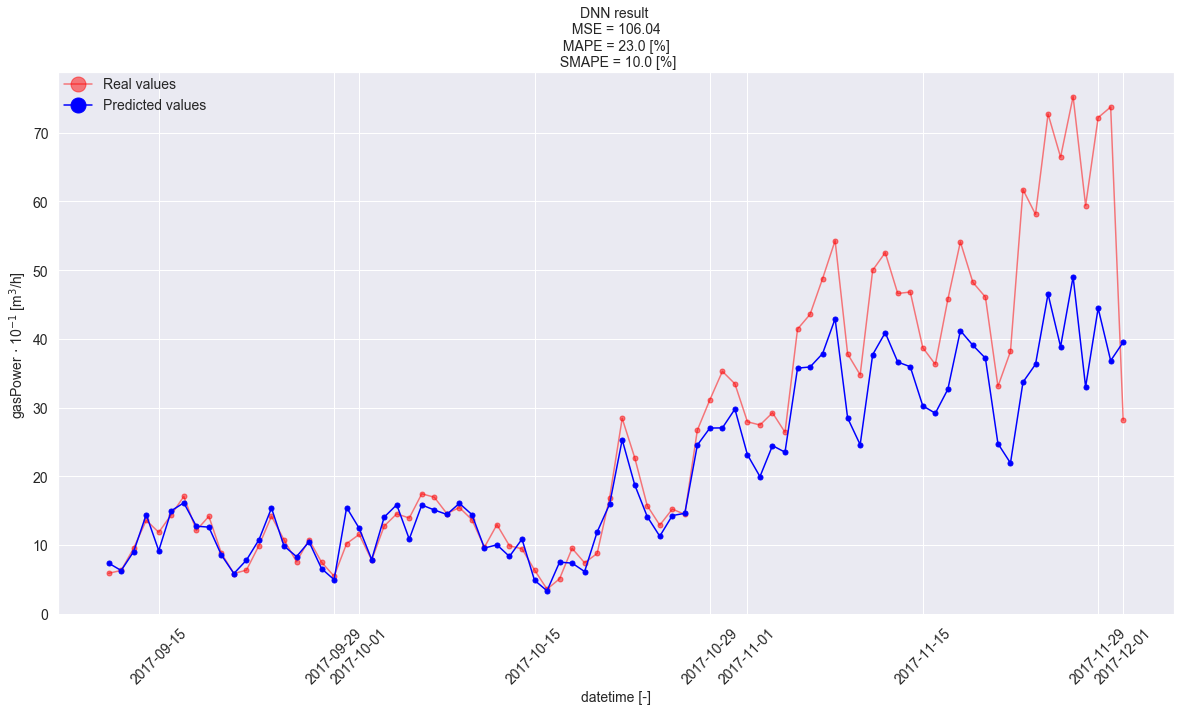

In [72]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='red', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='blue', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('DNN result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)